In [1]:
using Distributions
using StatsPlots
using LaTeXStrings
using CSV
using DataFrames
using StatisticalRethinking
using Logging
using Turing
using MCMCChains

# setting default attributes for plots
default(labels=false)

# 4.1 Why normal distributions are normal

Code 4.1

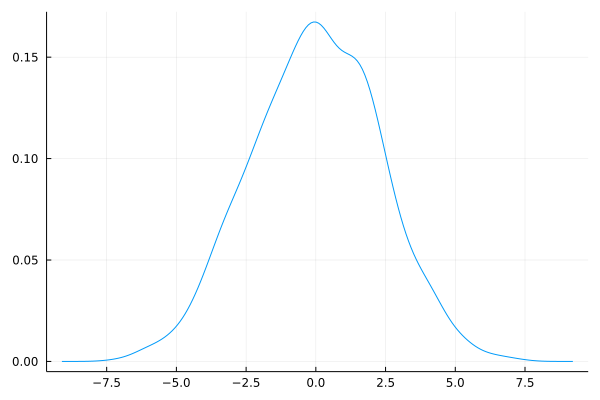

In [2]:
n = rand(Uniform(-1, 1), 1000, 16);
pos = sum.(eachrow(n));
density(pos)

Code 4.2

In [3]:
prod(1 .+ rand(Uniform(0, .1), 12))

1.700048318238439

Code 4.3

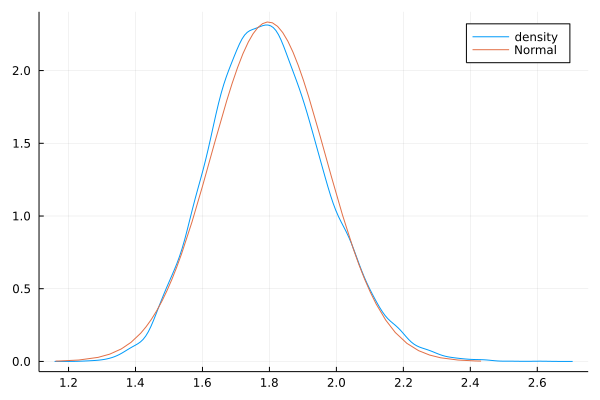

In [4]:
u = Uniform(0, .1)
growth = prod.(eachrow(1 .+ rand(u, 10000, 12)));

density(growth; label="density")
# overlay normal distribution
μ = mean(growth)
σ = std(growth)
plot!(Normal(μ, σ); label="Normal")

Code 4.4

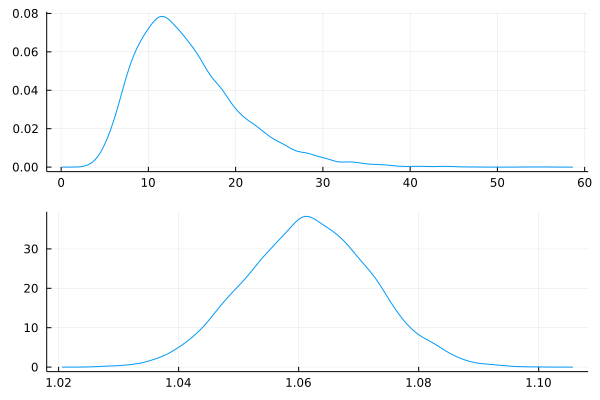

In [5]:
big = prod.(eachrow(1 .+ rand(Uniform(0, 0.5), 10000, 12)));
small = prod.(eachrow(1 .+ rand(Uniform(0, 0.01), 10000, 12)));
density([big, small]; layout=(2, 1))

Code 4.5

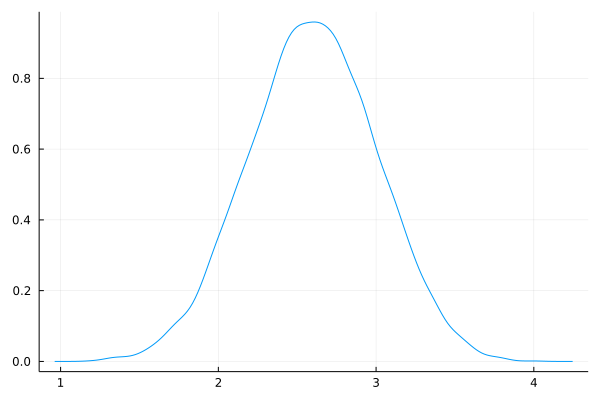

In [6]:
density(log.(big))

# 4.2 A language for describing models

Code 4.6

In [7]:
w = 6
n = 9
p_grid = range(0, 1; length=100)
bin_dens = [pdf(Binomial(n, p), w) for p in p_grid]
uni_dens = [pdf(Uniform(0, 1), p) for p in p_grid];
posterior = bin_dens .* uni_dens
posterior /= sum(posterior);

# 4.3 Gaussian model of height

Code 4.7

In [8]:
d = DataFrame(CSV.File("data/Howell1.csv"));

Code 4.8

In [9]:
describe(d)

4×7 DataFrame
 Row │ variable  mean        min       median    max       nmissing  eltype   
     │ Symbol    Float64     Real      Float64   Real      Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ height    138.264     53.975    148.59    179.07           0  Float64
   2 │ weight     35.6106     4.25242   40.0578   62.9926         0  Float64
   3 │ age        29.3444     0.0       27.0      88.0            0  Float64
   4 │ male        0.472426   0          0.0       1              0  Int64

Code 4.9

In [10]:
precis(d)

┌────────┬────────────────────────────────────────────────────────────┐
│  param │    mean      std     5.5%      50%    94.5%      histogram │
├────────┼────────────────────────────────────────────────────────────┤
│ height │ 138.264  27.6024  81.1086   148.59  165.735  ▁▁▁▂▂▂▂▂▂██▆▁ │
│ weight │ 35.6106  14.7192   9.3607  40.0578  54.5029  ▁▃▄▄▃▂▃▆██▅▃▁ │
│    age │ 29.3444  20.7469      1.0     27.0   66.135      █▆▆▆▆▃▃▁▁ │
│   male │  0.4724   0.4997      0.0      0.0      1.0    █▁▁▁▁▁▁▁▁▁█ │
└────────┴────────────────────────────────────────────────────────────┘


Code 4.10

In [11]:
d.height

544-element Array{Float64,1}:
 151.765
 139.7
 136.525
 156.845
 145.415
 163.83
 149.225
 168.91
 147.955
 165.1
 154.305
 151.13
 144.78
   ⋮
 156.21
 152.4
 162.56
 114.935
  67.945
 142.875
  76.835
 145.415
 162.56
 156.21
  71.12
 158.75

Code 4.11

In [12]:
d2 = d[d.age .>= 18,:];

Code 4.12

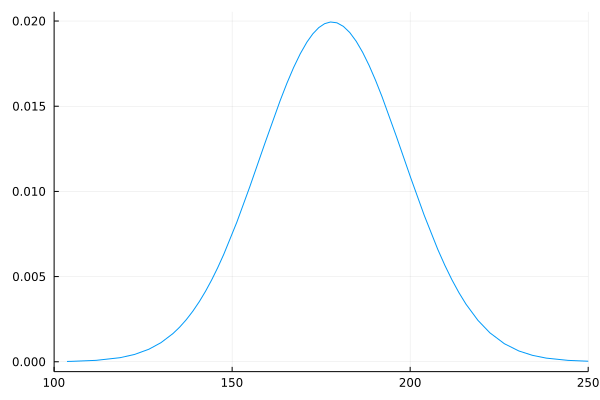

In [13]:
plot(Normal(178, 20); xlim=(100, 250))

Code 4.13

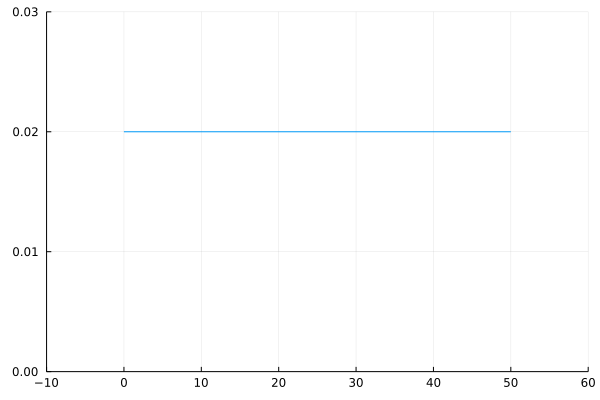

In [14]:
plot(Uniform(0, 50), xlim=(-10, 60), ylim=(0, 0.03))

Code 4.14

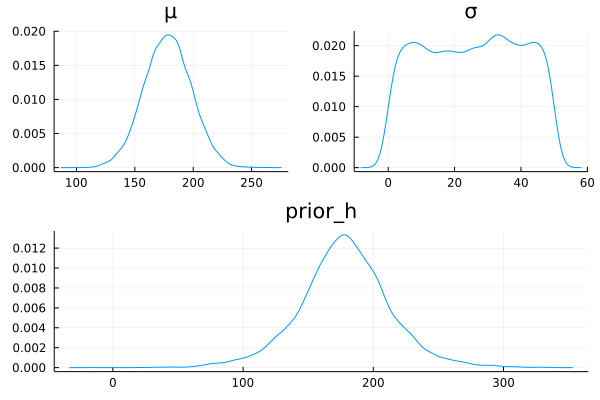

In [15]:
size = 10_000
sample_μ = rand(Normal(178, 20), size)
sample_σ = rand(Uniform(0, 50), size);
prior_h = [rand(Normal(μ, σ)) for (μ, σ) in zip(sample_μ, sample_σ)];

p1 = density(sample_μ; title="μ")
p2 = density(sample_σ; title="σ")
p3 = density(prior_h; title="prior_h")

plot(p1, p2, p3, layout=@layout [a b; c])

Code 4.15

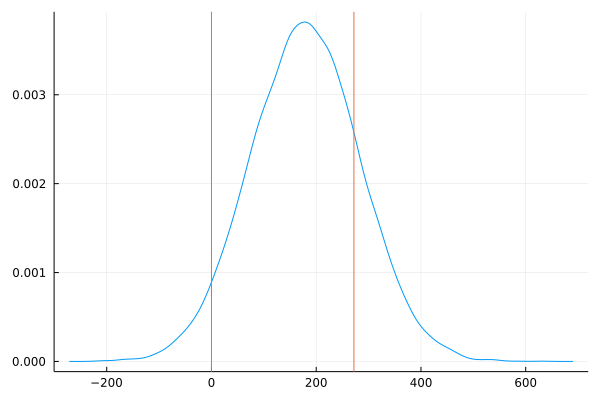

In [16]:
sample_μ = rand(Normal(178, 100), size)
prior_h = [rand(Normal(μ, σ)) for (μ, σ) in zip(sample_μ, sample_σ)];

density(prior_h)
vline!([0, 272])

Code 4.16

In [17]:
μ_list = range(150, 160; length=100)
σ_list = range(7, 9; length=100)

log_likelihood = [
    sum(logpdf(Normal(μ, σ), d2.height))
    for μ ∈ μ_list, σ ∈ σ_list
]
log_prod = log_likelihood .+ [
    logpdf(Normal(178, 20), μ) + logpdf(Uniform(0, 50), σ)
    for μ ∈ μ_list, σ ∈ σ_list
];

max_prod = maximum(log_prod)
prob = @. exp(log_prod - max_prod);

Code 4.17

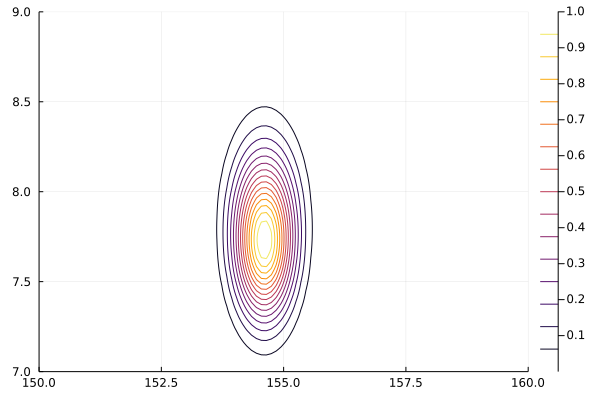

In [18]:
# note the transposition, that's due to Julia matrix order
contour(μ_list, σ_list, prob')

Code 4.18

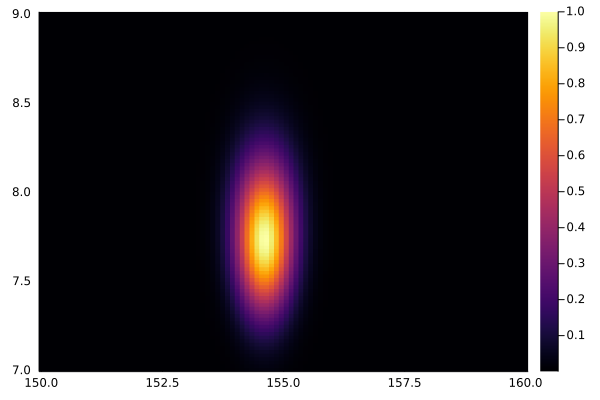

In [19]:
heatmap(μ_list, σ_list, prob')

Code 4.19

In [20]:
indices = collect(Iterators.product(1:length(μ_list), 1:length(σ_list)));
sample_idx = wsample(vec(indices), vec(prob), 10_000; replace=true)
sample_μ = μ_list[first.(sample_idx)]
sample_σ = σ_list[last.(sample_idx)];

Code 4.20

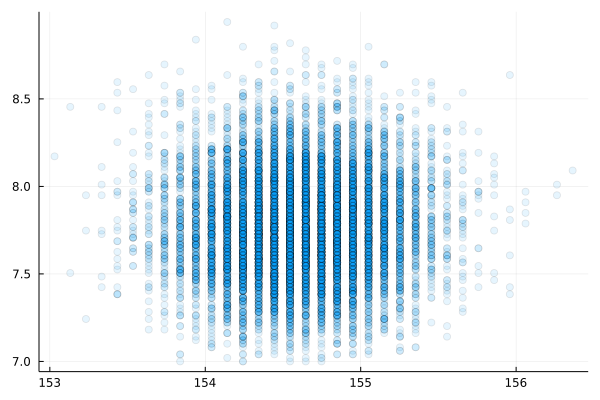

In [21]:
scatter(sample_μ, sample_σ; alpha=0.1)

Code 4.21

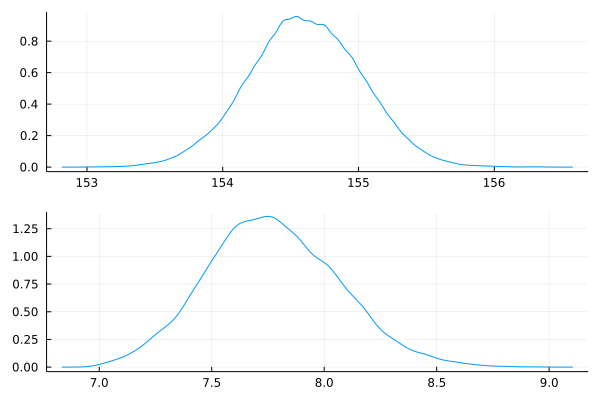

In [22]:
p1 = density(sample_μ)
p2 = density(sample_σ)
plot(p1, p2, layout=(2,1))

Code 4.22

In [23]:
println(hpdi(sample_μ, alpha=0.11))
println(hpdi(sample_σ, alpha=0.11))

[154.04040404040404, 155.25252525252526]
[7.242424242424242, 8.171717171717171]


Code 4.23

In [24]:
d3 = sample(d2.height, 20);

Code 4.24

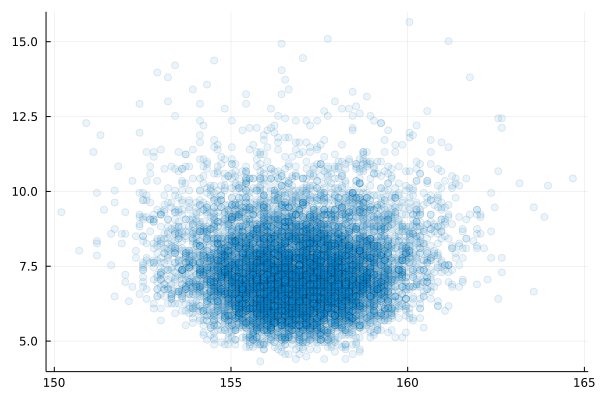

In [25]:
μ_list = range(150, 170; length=200)
σ_list = range(4, 20; length=200)

log_likelihood = [
    sum(logpdf(Normal(μ, σ), d3))
    for μ ∈ μ_list, σ ∈ σ_list
]
log_prod = log_likelihood .+ [
    logpdf(Normal(178, 20), μ) + logpdf(Uniform(0, 50), σ)
    for μ ∈ μ_list, σ ∈ σ_list
]

max_prod = maximum(log_prod)
prob2 = @. exp(log_prod - max_prod)

indices = collect(Iterators.product(1:length(μ_list), 1:length(σ_list)));
sample2_idx = wsample(vec(indices), vec(prob2), 10_000; replace=true)
sample2_μ = μ_list[first.(sample2_idx)]
sample2_σ = σ_list[last.(sample2_idx)]

scatter(sample2_μ, sample2_σ; alpha=0.1)

Code 4.25

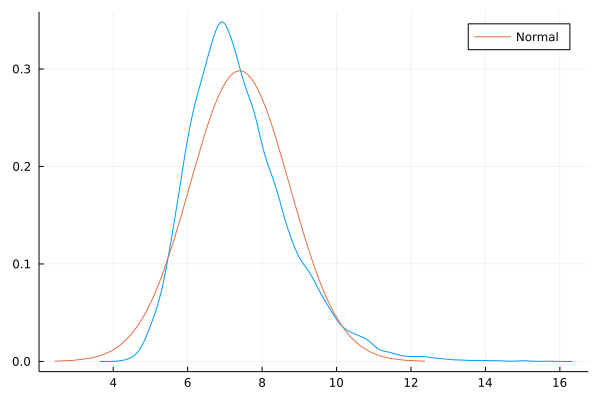

In [26]:
density(sample2_σ)
μ = mean(sample2_σ)
σ = std(sample2_σ)
plot!(Normal(μ, σ); label="Normal")

Code 4.26

In [27]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:];

Code 4.27

In [28]:
@model function model_height(height)
    μ ~ Normal(178, 20)
    σ ~ Uniform(0, 50)
    height ~ Normal(μ, σ)
end

model_height (generic function with 1 method)

Code 4.28

In [29]:
Logging.disable_logging(Logging.Warn)
m4_1 = sample(model_height(d2.height), NUTS(), 1000)
print(MCMCChains.header(m4_1))

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.43 seconds
Compute duration  = 5.43 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size


Code 4.29

In [30]:
display.(describe(m4_1; q=[0.055, 0.945]));

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           μ   154.5998    0.4141     0.0131    0.0150   873.7875    1.0017    ⋯
           σ     7.7633    0.2932     0.0093    0.0113   943.4146    1.0044    ⋯
                                                                1 column omitted


Quantiles
  parameters       5.5%      94.5% 
      Symbol    Float64    Float64 

           μ   153.9300   155.2625
           σ     7.3164     8.2504


Code 4.30

In [31]:
init_vals = [mean(d2.height), std(d2.height)]
chain = sample(model_height(d2.height), NUTS(), 1000, init_theta=init_vals)

Chains MCMC chain (1000×14×1 Array{Float64,3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.39 seconds
Compute duration  = 0.39 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           μ   154.5991    0.4142     0.0131    0.0139   851.8262    1.0005    ⋯
           σ     7.7700    0.2846     0.0090    0.0066   884.0689    0.9991    ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

  

Code 4.31

In [32]:
@model function model_height(height)
    μ ~ Normal(178, 0.1)
    σ ~ Uniform(0, 50)
    height ~ Normal(μ, σ)
end

m4_2 = sample(model_height(d2.height), NUTS(), 1000)
display.(describe(m4_2; q=[0.055, 0.945]));

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           μ   177.8625    0.0976     0.0031    0.0034   966.8203    0.9994    ⋯
           σ    24.6112    0.9398     0.0297    0.0287   815.4821    1.0002    ⋯
                                                                1 column omitted


Quantiles
  parameters       5.5%      94.5% 
      Symbol    Float64    Float64 

           μ   177.7002   178.0098
           σ    23.1114    26.1856


Code 4.32

In [33]:
cov(hcat(m4_1[:μ], m4_1[:σ]))

2×2 Array{Float64,2}:
  0.171497   -0.0010999
 -0.0010999   0.0859938

Code 4.33

In [34]:
c = cov(hcat(m4_1[:μ], m4_1[:σ]))
cov2cor(c, diag(c))

2×2 Array{Float64,2}:
  1.0        -0.0745811
 -0.0745811   1.0

Code 4.34

In [35]:
# resetrange is needed due to bug in MCMCChains: https://github.com/TuringLang/MCMCChains.jl/issues/324
# once it will be fixed, direct sampling from the chain will be possible
samp_chain = sample(resetrange(m4_1), 10_000)
samp_df = DataFrame(samp_chain)
first(samp_df, 5)

5×2 DataFrame
 Row │ μ        σ       
     │ Float64  Float64 
─────┼──────────────────
   1 │ 156.013  8.18125
   2 │ 154.434  7.15629
   3 │ 154.729  7.63413
   4 │ 155.078  7.48589
   5 │ 154.196  8.14877

Code 4.35

In [36]:
precis(samp_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%   histogram │
├───────┼────────────────────────────────────────────────────────┤
│     μ │ 154.602  0.4179  153.927  154.606  155.275     ▁▂▇█▃▁▁ │
│     σ │  7.7631  0.2902   7.3202   7.7485   8.2449  ▁▁▃▆█▇▄▂▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 4.36

In [37]:
data = hcat(m4_1[:μ], m4_1[:σ])
μ = mean(data, dims=1)
σ = cov(data)
mvn = MvNormal(vec(μ), σ)
post = rand(mvn, 10_000);
print(mvn)

FullNormal(
dim: 2
μ: [154.59980370263483, 7.76334927298231]
Σ: [0.17149708950710787 -0.0010998983503687518; -0.0010998983503687518 0.08599377911438741]
)


# 4.4 Linear predictions

Code 4.37

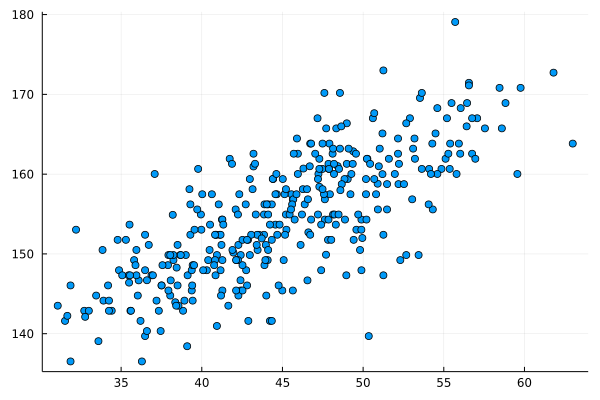

In [38]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:];
# fancy way of doing scatter(d2.weight, d2.height)
@df d2 scatter(:weight, :height)

Code 4.38

In [39]:
Random.seed!(2971)
N = 100
a = rand(Normal(178, 20), N)
b = rand(Normal(0, 10), N);

Code 4.39

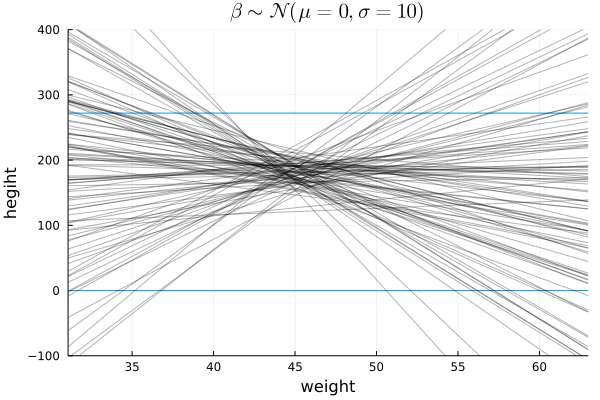

In [40]:
p = hline([0, 272]; ylims=(-100, 400), xlabel="weight", ylabel="hegiht")
title!(L"\beta \sim \mathcal{N}(\mu=0,\sigma=10)")

x_mean = mean(d2.weight)
xlims = extrema(d2.weight)  # getting min and max in one pass

for (α, β) ∈ zip(a, b)
    plot!(x -> α + β * (x - x_mean); xlims=xlims, c=:black, alpha=0.3)
end
display(p)

Code 4.40

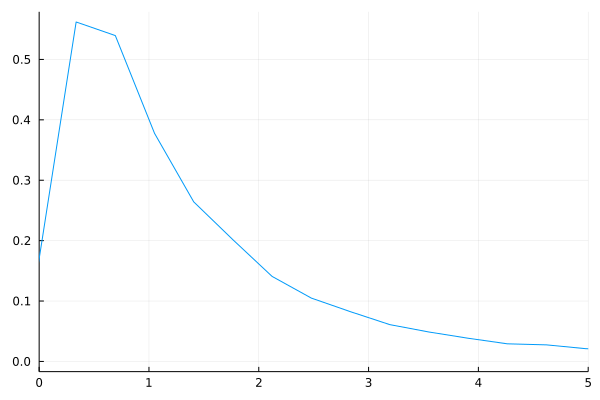

In [41]:
b = rand(LogNormal(0, 1), 10_000)
density(b, xlims=(0, 5), bandwidth=0.1)

Code 4.41

In [72]:
Random.seed!(2971)
N = 100
a = rand(Normal(178, 20), N)
b = rand(LogNormal(0, 1), N);

Code 4.42

In [73]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:]
xbar = mean(d2.weight)

@model function height_regr_model(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    μ = @. a + b * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3 = sample(height_regr_model(d2.weight, d2.height), NUTS(), 1000)
m4_3 = resetrange(m4_3);

Code 4.43

In [74]:
@model function height_regr_model_exp(weight, height)
    a ~ Normal(178, 20)
    log_b ~ Normal(0, 1)
    μ = @. a + exp(log_b) * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3b = sample(height_regr_model_exp(d2.weight, d2.height), NUTS(), 1000);

Code 4.44

In [75]:
m4_3_df = DataFrame(m4_3)
precis(m4_3_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │ 154.598  0.2529  154.203  154.589  155.023       ▁▁▂▅██▄▂▁ │
│     b │  0.9029  0.0421   0.8378   0.9019   0.9702  ▁▁▁▂▅▆██▇▄▃▁▁▁ │
│     σ │  5.1021  0.1898   4.7961   5.1004   5.4229   ▁▂▄▆██▅▃▃▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 4.45

In [76]:
round.(cov(Matrix(m4_3_df)), digits=3)

3×3 Array{Float64,2}:
 0.064  0.0    0.002
 0.0    0.002  0.001
 0.002  0.001  0.036

Code 4.46

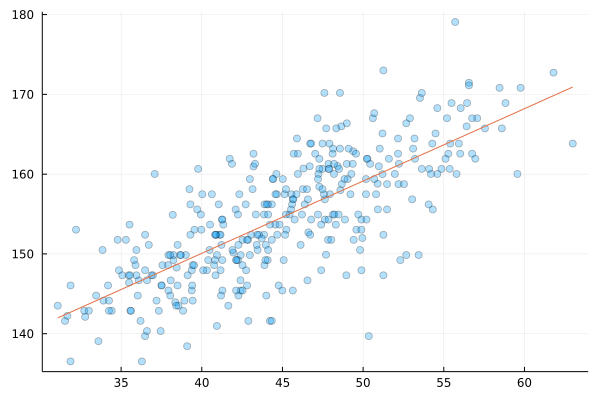

In [78]:
p = @df d2 scatter(:weight, :height; alpha=0.3)

chain = resetrange(m4_3)
samples = sample(chain, 1000)

a_map = mean(samples[:a])
b_map = mean(samples[:b])
plot!(x -> a_map + b_map*(x-xbar))

Code 4.47

In [79]:
chain = resetrange(m4_3)
post = sample(chain, 1000)
post_df = DataFrame(post)
post_df[1:5,:]

5×3 DataFrame
 Row │ a        b         σ       
     │ Float64  Float64   Float64 
─────┼────────────────────────────
   1 │ 154.608  0.928567  4.71459
   2 │ 154.507  0.934093  5.16669
   3 │ 154.612  0.895449  5.00531
   4 │ 154.717  0.840483  5.30036
   5 │ 154.67   0.896461  4.95129

Code 4.48

In [80]:
N = 10
dN = d2[1:N,:]

@model function height_regr_model_N(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    m_weight = mean(weight)
    μ = @. a + b * (weight - m_weight)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

mN = sample(height_regr_model(dN.weight, dN.height), NUTS(), 1000)
mN = resetrange(mN);

Code 4.49

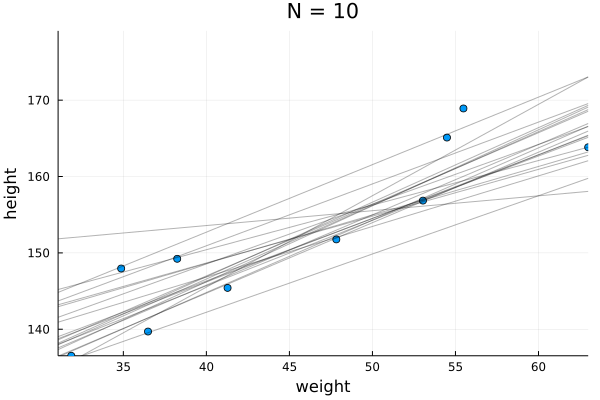

In [81]:
post = sample(mN, 20)
post_df = DataFrame(post);

xlims = extrema(d2.weight)
ylims = extrema(d2.height)
p = @df dN scatter(:weight, :height; xlims=xlims, ylims=ylims)
title!("N = $N"; xlab="weight", ylab="height")

x_mean = mean(dN.weight)
for (a, b) ∈ zip(post_df.a, post_df.b)
    plot!(x -> a + b * (x-x_mean); c="black", alpha=0.3)
end
display(p)

Code 4.50

In [82]:
post = sample(m4_3, 1000)
post_df = DataFrame(post)
μ_at_50 = @. post_df.a + post_df.b * (50 - xbar);

Code 4.51

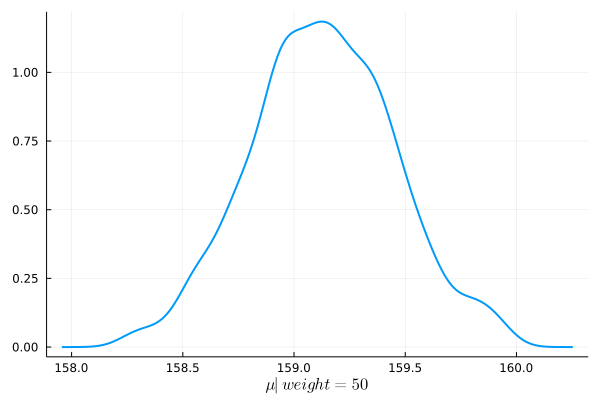

In [83]:
density(μ_at_50; lw=2, xlab=L"\mu|weight=50")

Code 4.52

In [84]:
percentile(μ_at_50, [5.5, 94.5])

2-element Array{Float64,1}:
 158.59390779217986
 159.63460094865837

Code 4.53

In [54]:
μ = StatisticalRethinking.link(post_df, [:a :b], d2.weight, xbar);
μ = hcat(μ...);
Base.size(μ), μ[1:5,1]

((1000, 352), [156.63354849360985, 157.07979812568936, 157.10028339512775, 156.83429657878378, 157.19313190871827])

Code 4.54

In [55]:
weight_seq = 25:70
μ = StatisticalRethinking.link(post_df, [:a :b], weight_seq, xbar);
μ = hcat(μ...);
Base.size(μ), μ[1:5,1]

((1000, 46), [138.30923749453672, 135.75399175544229, 137.28069267182403, 136.5072234418965, 136.22166653335003])

Code 4.55

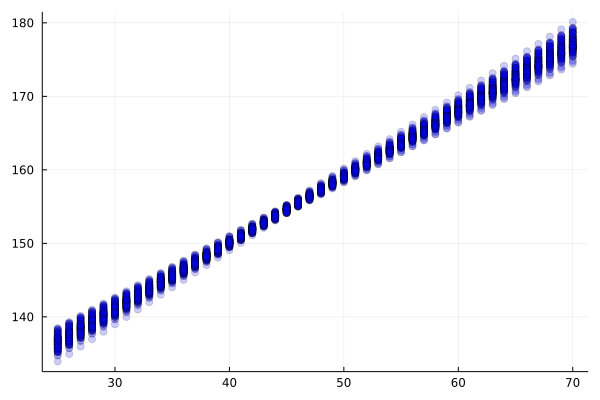

In [56]:
p = plot()
for i in 1:100
    scatter!(weight_seq, μ[i,:]; c=:blue, alpha=0.2)
end
display(p)

Code 4.56

In [57]:
μ_mean = mean.(eachcol(μ))
# small trick here: we wrap second argument into tuple to broadcast it to every percentile application
# the same could be done with: map(x -> percentile(x, [5.5, 94.5]), eachcol(μ))
μ_PI = percentile.(eachcol(μ), ([5.5, 94.5],))
μ_PI = vcat(μ_PI'...);

Code 4.57

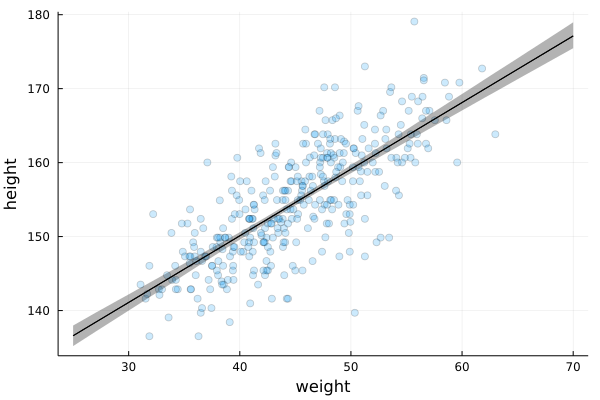

In [58]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)

Code 4.58

In [59]:
post = sample(m4_3, 1000)
post = DataFrame(post)

weight_seq = 25:70
μ = map(w -> post.a + post.b * (w - xbar), weight_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_CI = percentile.(eachcol(μ), ([5.5, 94.5],));

Code 4.59

In [60]:
sim_height = simulate(post, [:a, :b, :σ], weight_seq .- xbar);
Base.size(sim_height), sim_height[1:5,1]

((1000, 46), [133.14488255925087, 137.94992213131675, 136.14293515163945, 141.93392625663586, 133.75319660927357])

Code 4.60

In [61]:
height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],))
height_PI = vcat(height_PI'...);

Code 4.61

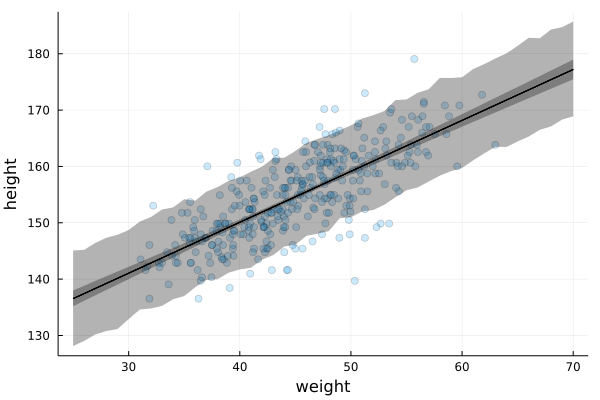

In [62]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.62

In [63]:
post = sample(m4_3, 10_000)
post = DataFrame(post)
sim_height = simulate(post, [:a, :b, :σ], weight_seq .- xbar)
height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],))
height_PI = vcat(height_PI'...);

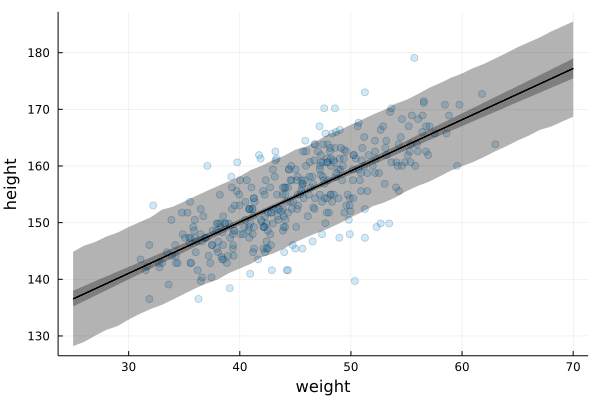

In [64]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.63

In [65]:
post = sample(m4_3, 1000)
post = DataFrame(post)

sim_height = [
    [
        rand(Normal(a + b * (w - xbar), σ))
        for (a, b, σ) ∈ zip(post.a, post.b, post.σ)
    ]
    for w ∈ weight_seq
]
sim_height = hcat(sim_height...)

height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],));
height_PI = vcat(height_PI'...);

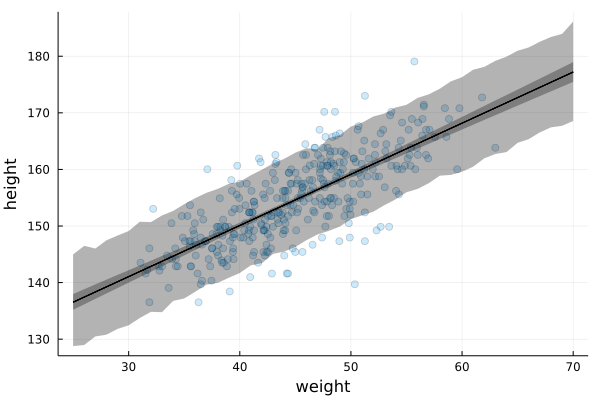

In [66]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

# 4.5 Curves from lines

Code 4.64

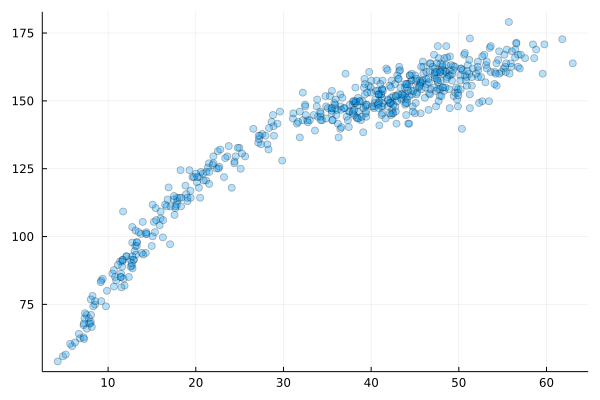

In [69]:
d = DataFrame(CSV.File("data/Howell1.csv"))
scatter(d.weight, d.height; alpha=0.3)

Code 4.65

In [91]:
d[!, :weight_s] = standardize(ZScoreTransform, d.weight)
d[!, :weight_s2] = d.weight_s.^2;

@model function height_regr_m2(weight_s, weight_s2, height)
    a ~ Normal(178, 20)
    b1 ~ LogNormal(0, 1)
    b2 ~ Normal(0, 1)
    μ = @. a + b1 * weight_s + b2 * weight_s2
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_5 = sample(height_regr_m2(d.weight_s, d.weight_s2, d.height), NUTS(), 1000)
m4_5 = resetrange(m4_5)
# due to the problem in StatisticalRethinking, need to do explicit conversion:
# https://github.com/StatisticalRethinkingJulia/StatisticalRethinking.jl/issues/118
m4_5_df = DataFrame(a=vec(m4_5[:a].data), b1=vec(m4_5[:b1].data), b2=vec(m4_5[:b2].data), σ=vec(m4_5[:σ].data));

Code 4.66

In [92]:
precis(m4_5_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ 146.053  0.3567  145.484  146.049  146.618  ▁▁▁▃▅██▇▄▂▁▁▁ │
│    b1 │ 21.7305    0.29  21.2931  21.7218  22.2205     ▁▁▃▆█▇▃▂▁▁ │
│    b2 │ -7.7983  0.2689  -8.2034  -7.8062  -7.3743     ▁▁▂▅██▅▂▁▁ │
│     σ │  5.8123  0.1904   5.5372   5.7951   6.1243        ▁▃█▇▃▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 4.67

In [110]:
Random.seed!(1)
df = sample(m4_5_df, 1000)
weight_seq = range(-2.2, 2; length=30)

# explicit logic of link
mu = [
    df.a + df.b1 * w_s + df.b2 * w_s^2
    for w_s ∈ weight_seq
]

mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = percentile.(eachcol(mu), ([5.5, 94.5],))
mu_PI = vcat(mu_PI'...)

# explicit logic of sim
sim_height = [
    [
        rand(Normal(row.a + row.b1 * w_s + row.b2 * w_s^2, row.σ))
        for row ∈ eachrow(df)
    ]
    for w_s ∈ weight_seq
]
sim_height = hcat(sim_height...);

height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],))
height_PI = vcat(height_PI'...);

Code 4.68

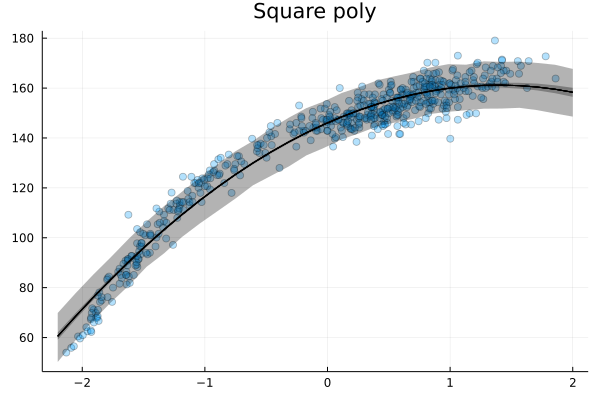

In [111]:
p_square = @df d scatter(:weight_s, :height; alpha=0.3, title="Square poly")
plot!(weight_seq, mu_mean; c=:black)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=mu_PI, fillalpha=0.3)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.69

In [97]:
d[!, :weight_s3] = d.weight_s.^3;

@model function height_regr_m3(weight_s, weight_s2, weight_s3, height)
    a ~ Normal(178, 20)
    b1 ~ LogNormal(0, 1)
    b2 ~ Normal(0, 1)
    b3 ~ Normal(0, 1)
    μ = @. a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_6 = sample(height_regr_m3(d.weight_s, d.weight_s2, d.weight_s3, d.height), NUTS(), 1000)
m4_6 = resetrange(m4_6)
# due to the problem in StatisticalRethinking, need to do explicit conversion:
# https://github.com/StatisticalRethinkingJulia/StatisticalRethinking.jl/issues/118
m4_6_df = DataFrame(
    a=vec(m4_6[:a].data), 
    b1=vec(m4_6[:b1].data), 
    b2=vec(m4_6[:b2].data), 
    b3=vec(m4_6[:b3].data), 
    σ=vec(m4_6[:σ].data)
);
precis(m4_6_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ 146.406  0.3123  145.904    146.4  146.898    ▁▃▅██▆▃▁▁ │
│    b1 │ 15.2314  0.4776  14.4681   15.219  16.0147      ▁▂▅█▅▁▁ │
│    b2 │ -6.2092  0.2636   -6.627  -6.2193  -5.7772    ▁▁▂▆██▄▂▁ │
│    b3 │  3.5811  0.2312    3.218   3.5813   3.9483    ▁▁▁▄██▄▁▁ │
│     σ │  4.8606  0.1573     4.62   4.8588   5.1113  ▁▁▂▄██▇▅▂▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


In [112]:
Random.seed!(1)
df = sample(m4_6_df, 1000)
weight_seq = range(-2.2, 2; length=30)

# explicit logic of link
mu = [
    df.a + df.b1 * w_s + df.b2 * w_s^2 + df.b3 * w_s^3
    for w_s ∈ weight_seq
]

mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = percentile.(eachcol(mu), ([5.5, 94.5],))
mu_PI = vcat(mu_PI'...)

# explicit logic of sim
sim_height = [
    [
        rand(Normal(row.a + row.b1 * w_s + row.b2 * w_s^2 + row.b3 * w_s^3, row.σ))
        for row ∈ eachrow(df)
    ]
    for w_s ∈ weight_seq
]
sim_height = hcat(sim_height...);

height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],))
height_PI = vcat(height_PI'...);

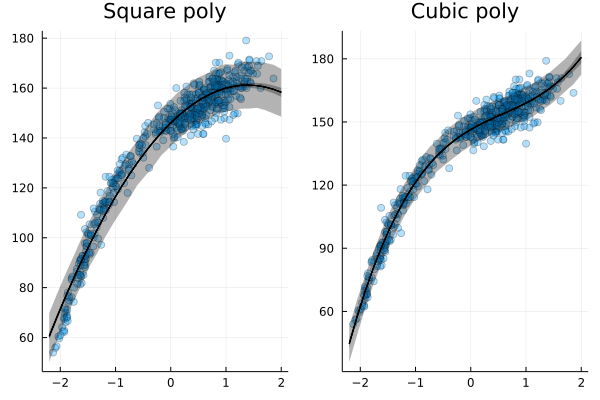

In [113]:
p_cubic = @df d scatter(:weight_s, :height; alpha=0.3, title="Cubic poly")
plot!(weight_seq, mu_mean; c=:black)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=mu_PI, fillalpha=0.3)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

plot(p_square, p_cubic; layout=(1, 2))

Code 4.70 and 4.71

Looks like Julia plots don't support change of ticks proposed in the book.
But much more natural way will be to remap values we're plotting back to the original scale.
Example of this is below.

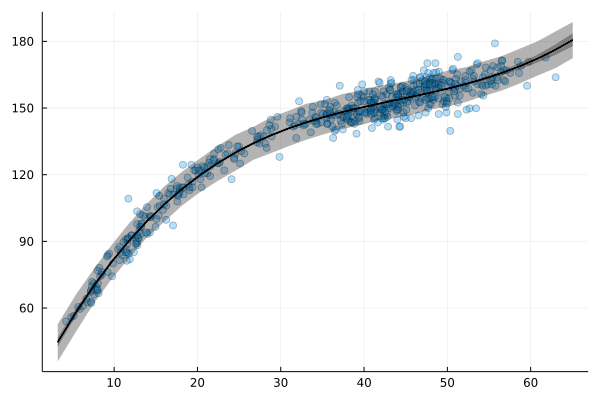

In [138]:
μ = mean(d.weight)
σ = std(d.weight)
w = @. d.weight_s * σ + μ
scatter(w, d.height; alpha=0.3)

w_s = @. weight_seq * σ + μ
plot!(w_s, mu_mean; c=:black)
plot!(w_s, [mu_mean mu_mean]; c=:black, fillrange=mu_PI, fillalpha=0.3)
plot!(w_s, [mu_mean mu_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)